# IMPORTS

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional,TextVectorization
from tensorflow.keras.optimizers import Adam, Optimizer
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
import wandb
from pandas import read_csv, get_dummies
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
import os
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
import string # Used for cleaning punctuation
from gensim.parsing.preprocessing import remove_stopwords #used to remove stop words (unlike nltk it considers however as a stopword)
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup # Used for Removing HTML tags
from matplotlib import pyplot as plt

# DATA

## INSTALLING DATA

In [15]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other




  0%|          | 0.00/25.7M [00:00<?, ?B/s]
  4%|▍         | 1.00M/25.7M [00:00<00:16, 1.59MB/s]
  8%|▊         | 2.00M/25.7M [00:00<00:10, 2.45MB/s]
 12%|█▏        | 3.00M/25.7M [00:01<00:08, 2.93MB/s]
 16%|█▌        | 4.00M/25.7M [00:01<00:06, 3.29MB/s]
 19%|█▉        | 5.00M/25.7M [00:01<00:06, 3.48MB/s]
 23%|██▎       | 6.00M/25.7M [00:02<00:05, 3.48MB/s]
 27%|██▋       | 7.00M/25.7M [00:02<00:05, 3.75MB/s]
 31%|███       | 8.00M/25.7M [00:02<00:04, 3.78MB/s]
 35%|███▌      | 9.00M/25.7M [00:02<00:04, 3.84MB/s]
 39%|███▉      | 10.0M/25.7M [00:03<00:04, 3.77MB/s]
 43%|████▎     | 11.0M/25.7M [00:03<00:04, 3.78MB/s]
 47%|████▋     | 12.0M/25.7M [00:03<00:04, 3.26MB/s]
 51%|█████     | 13.0M/25.7M [00:03<00:03, 3.97MB/s]
 54%|█████▍    | 14.0M/25.7M [00:04<00:03, 3.86MB/s]
 58%|█████▊    | 15.0M/25.7M [00:04<00:03, 3.28MB/s]
 62%|██████▏   | 16.0M/25.7M [00:04<00:03, 3.28MB/s]
 66%|██████▌   | 17.0M/25.7M [00:05<00:02, 3.47MB/s]
 70%|███████   | 18.0M/25.7M [00:05<00:02, 3.60MB/s]
 

In [19]:
with ZipFile('imdb-dataset-of-50k-movie-reviews.zip', 'r') as extractor:
    extractor.extractall()

In [20]:
os.remove('imdb-dataset-of-50k-movie-reviews.zip')

## READING & ADJUSTING

In [3]:
data = read_csv("IMDB Dataset.csv")
data['sentiment'] = get_dummies(data['sentiment'],drop_first=True, dtype=int)['positive'] 
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


## CLEANING & PREPROCESSING

In [4]:
def preprocess(data):
   lemmatizer = WordNetLemmatizer()
   temptxt = BeautifulSoup(data, 'html.parser').get_text()

   temptxt= temptxt.translate(str.maketrans('', '', string.punctuation)) #Removes punctuations from string

   temptxt= temptxt.lower() #Applies lowercase to the entire review string

   temptxt= remove_stopwords(temptxt) #Removes stopwords from the review string

   temptxt= temptxt.replace('"', '')# Removing double qoutes

   word_list = word_tokenize(temptxt) #Transforms review from String to a 1d array where each word is an element to lemmatize seperatly
   clean_words= ' '.join([lemmatizer.lemmatize(w) for w in word_list])

   return clean_words

In [5]:
data['review'] = data['review'].apply(preprocess)

C:\Users\Katie\AppData\Local\Temp\ipykernel_5488\4129221218.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  temptxt = BeautifulSoup(data, 'html.parser').get_text()


## SPLITTING

In [6]:
train, test = train_test_split(data, train_size = 0.7, shuffle = True, random_state=42)

In [7]:
print("Original data split %")
print(f"Train: {int((len(train)/len(data))*100)}%", end="\t")
print(f"Test: {int((len(test)/len(data))*100)}%")

Original data split %
Train: 70%	Test: 30%


# RNN

## WandB

In [82]:
wandb.init(
    # set the wandb project where this run will be logged
    project="Movie Review Sentiment Classification with Tranformers",
    name = 'RNN',

)


## GPU CHECK

In [15]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## MODEL

In [16]:
max_tokens = 1000
max_len = 100

encoder = TextVectorization(
  max_tokens=max_tokens,
  output_mode="int",
  output_sequence_length=max_len,
)

In [17]:
encoder.adapt(train['review'])

In [78]:
RNN_model = Sequential([
    Input(shape=(1,), dtype="string"),
    encoder,
    Embedding((max_tokens + 1), 128),
    Bidirectional(LSTM(16, # was 64
                       #return_tensor=True
                       )),
    # Bidirectional(LSTM(32)),

    # first dense layer units were 64
    Dense(16, activation="relu"),
    Dense(1, activation="sigmoid"),
])

In [79]:
RNN_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=4e-6),
            loss='binary_crossentropy',
            metrics=['accuracy'],
            )

In [80]:
with tf.device('/GPU:0'):
    history = RNN_model.fit(train['review'],
                        train['sentiment'],
                            epochs=20,
                            batch_size=8,
                            verbose=1,
                            validation_split=0.2)

Epoch 1/20
3500/3500 [==============================] - 87s 24ms/step - loss: 0.6925 - accuracy: 0.5251 - val_loss: 0.6921 - val_accuracy: 0.5443
Epoch 2/20
3500/3500 [==============================] - 83s 24ms/step - loss: 0.6917 - accuracy: 0.5491 - val_loss: 0.6911 - val_accuracy: 0.5644
Epoch 3/20
3500/3500 [==============================] - 84s 24ms/step - loss: 0.6906 - accuracy: 0.5721 - val_loss: 0.6898 - val_accuracy: 0.5820
Epoch 4/20
3500/3500 [==============================] - 84s 24ms/step - loss: 0.6889 - accuracy: 0.5874 - val_loss: 0.6879 - val_accuracy: 0.5989
Epoch 5/20
3500/3500 [==============================] - 84s 24ms/step - loss: 0.6865 - accuracy: 0.6119 - val_loss: 0.6851 - val_accuracy: 0.6196
Epoch 6/20
3500/3500 [==============================] - 84s 24ms/step - loss: 0.6827 - accuracy: 0.6365 - val_loss: 0.6801 - val_accuracy: 0.6370
Epoch 7/20
3500/3500 [==============================] - 84s 24ms/step - loss: 0.6747 - accuracy: 0.6629 - val_loss: 0.6677 -

In [83]:
for i in range(history.params['epochs']):

    wandb.log({'epoch': i+1,
            'train loss': history.history['loss'][i],
            'train accuracy': history.history['accuracy'][i],
            'val loss': history.history['val_loss'][i],
            'val accuracy': history.history['val_accuracy'][i],
                })

In [84]:
wandb.finish()

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train accuracy,▁▂▂▂▃▃▄▅▆▇▇▇▇███████
train loss,███████▇▅▄▃▃▂▂▂▂▁▁▁▁
val accuracy,▁▂▂▂▃▃▄▆▇▇▇▇████████
val loss,██████▇▆▄▃▃▂▂▂▂▂▁▁▁▁
epoch,20
train accuracy,0.83932
train loss,0.39124
val accuracy,0.81729
val loss,0.41553


6

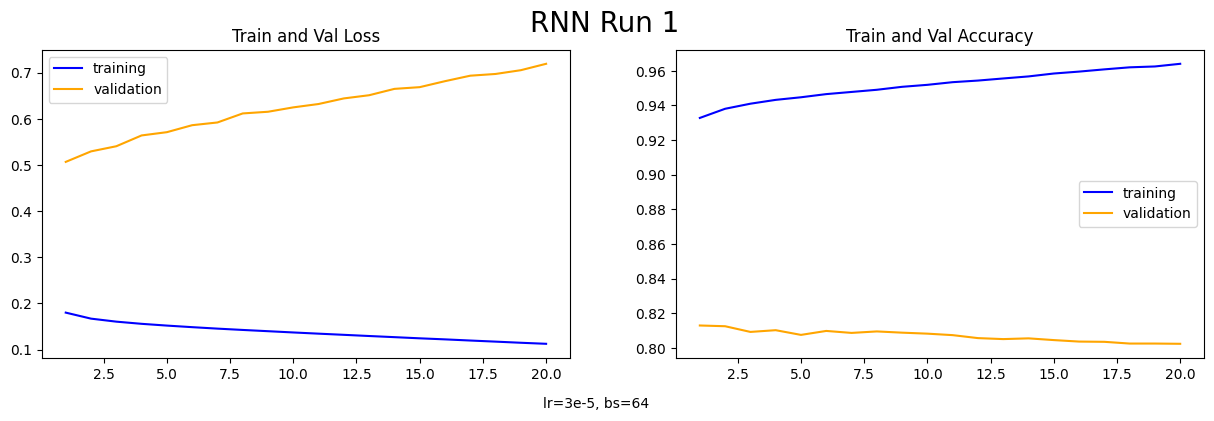

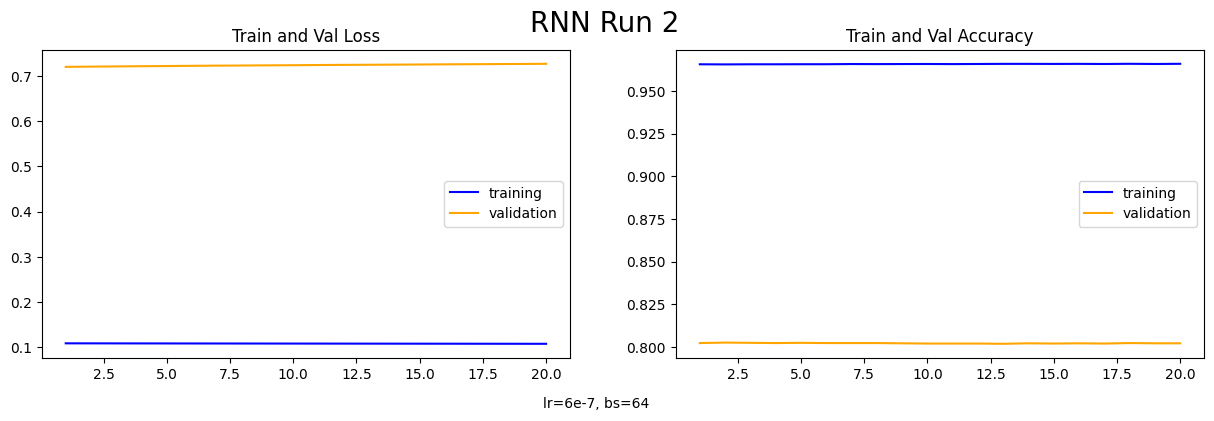

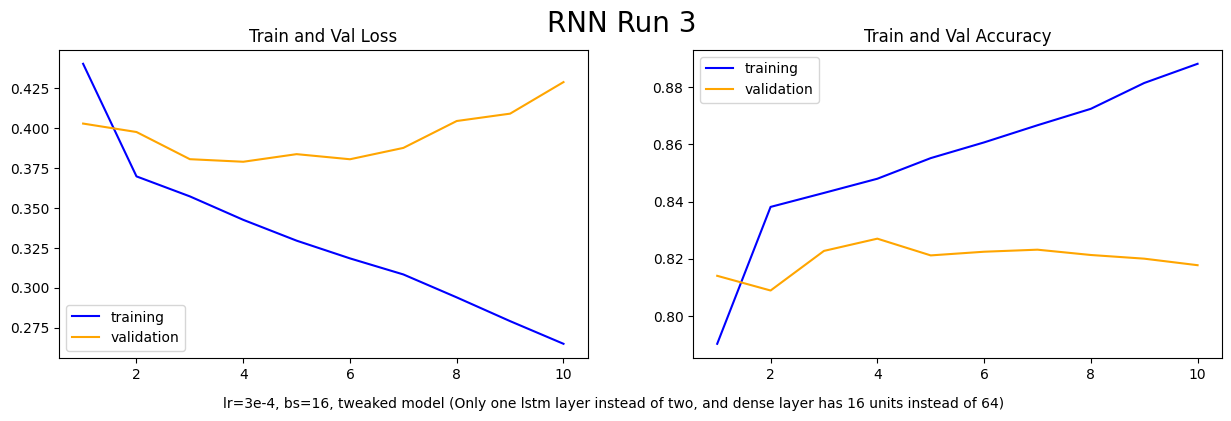

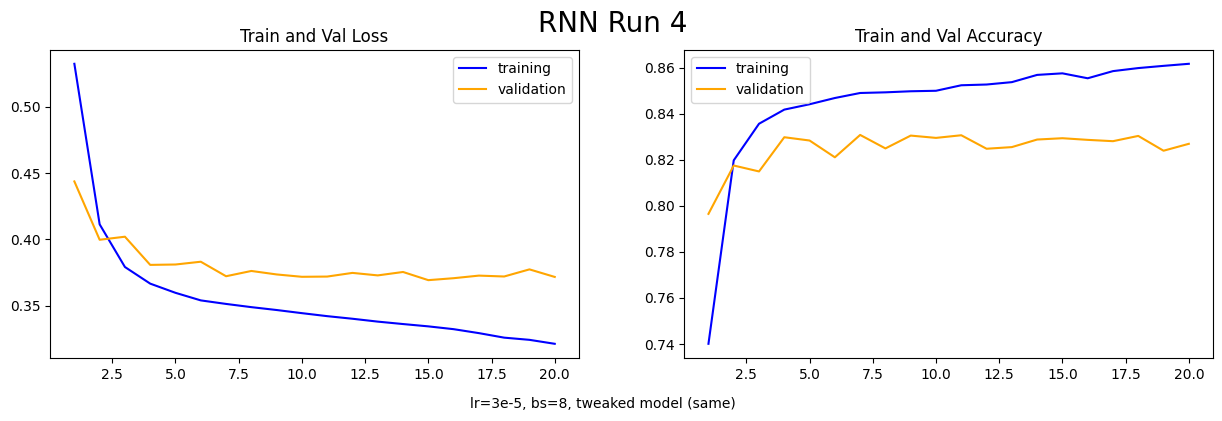

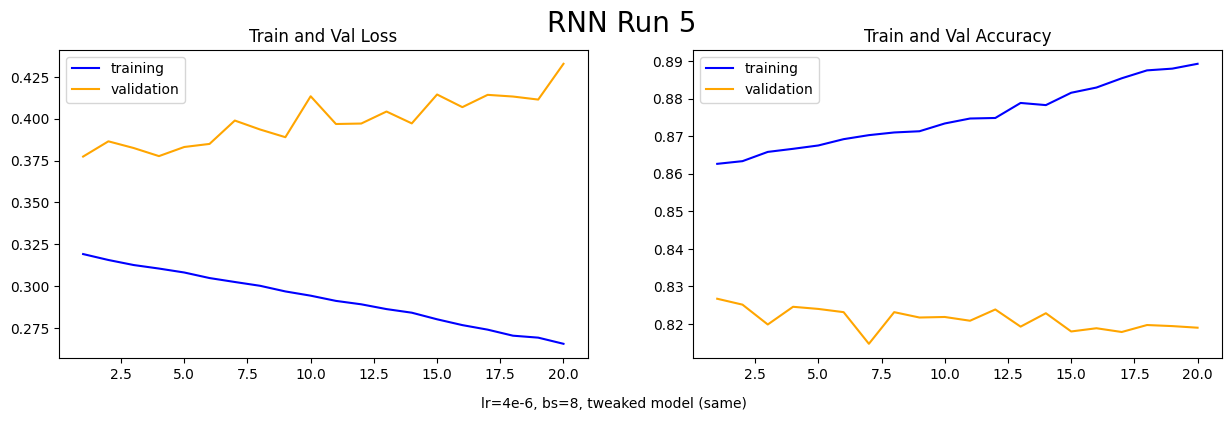

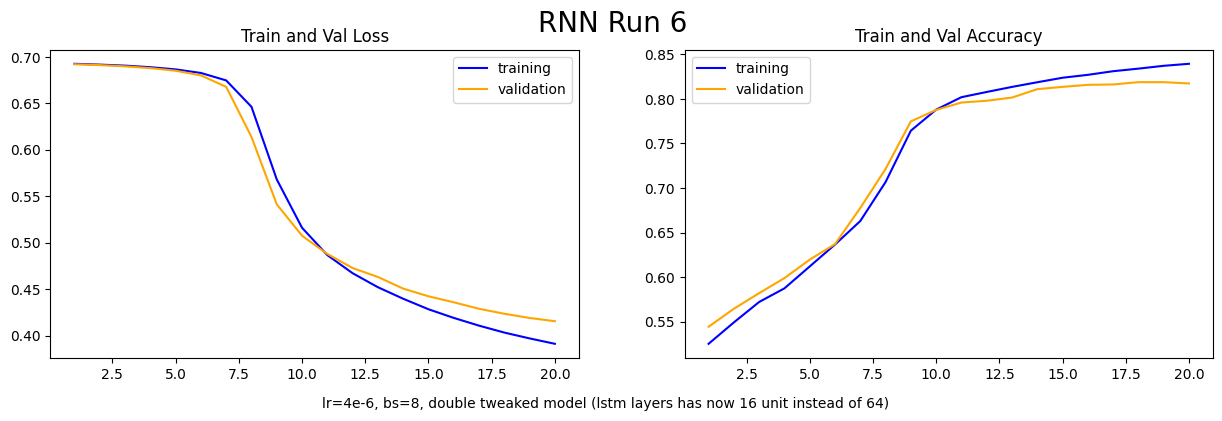

In [64]:
api = wandb.Api()
runs = api.runs("SoloWork/Movie Review Sentiment Classification with Tranformers")

for i,run in enumerate(runs):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,4))
    history_df = run.history()
    ax1.plot(history_df['epoch'], history_df['train loss'], label='training', color = 'b')
    ax1.plot(history_df['epoch'], history_df['val loss'],label='validation', color = 'orange')
    ax1.set_title('Train and Val Loss')
    ax1.legend()
    ax2.plot(history_df['epoch'], history_df['train accuracy'], label='training', color = 'b')
    ax2.plot(history_df['epoch'], history_df['val accuracy'], label='validation', color = 'orange')
    ax2.set_title('Train and Val Accuracy')
    ax2.legend()
    fig.suptitle(f"{run.name} Run {i+1}", fontsize=20)
    plt.annotate(run.notes, xy = (-0.15, -0.15),
            xycoords='axes fraction',
            ha='center',
            va="center",
            fontsize=10)
    plt.show()
